# IAF neurons singularity

This notebook describes how NEST handles the singularities appearing in the ODE's of integrate-and-fire model neurons with alpha- or exponentially-shaped current, when the membrane and the synaptic time-constants are identical.


In [1]:
import sympy as sp
sp.init_printing(use_latex=True)
from sympy.matrices import zeros
tau_m, tau_s, C, h = sp.symbols('tau_m, tau_s, C, h')

For alpha-shaped currents we have:

In [2]:
A = sp.Matrix([[-1/tau_s,0,0],[1,-1/tau_s,0],[0,1/C,-1/tau_m]])

## Non-singular case ($\tau_m\neq \tau_s$) 
The propagator is: 

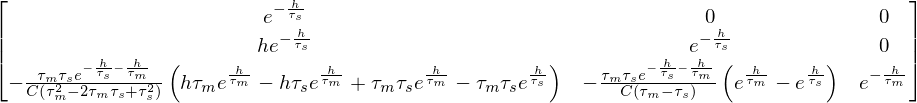

In [3]:
PA = sp.simplify(sp.exp(A*h))
PA

Note that the entry in the third line and the second column $A_{32}$ would also appear in the propagator matrix in case of an exponentially shaped current

## Singular case ($\tau_m = \tau_s$) 
We have

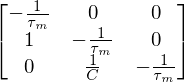

In [4]:
As = sp.Matrix([[-1/tau_m,0,0],[1,-1/tau_m,0],[0,1/C,-1/tau_m]])
As

The propagator is

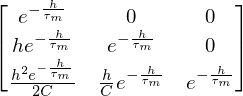

In [5]:
PAs = sp.simplify(sp.exp(As*h))
PAs

## Numeric stability of propagator elements
For the lines $\tau_s\rightarrow\tau_m$ the entry $PA_{32}$ becomes numerically unstable, since denominator and enumerator go to zero.

$1.$ We show that $PAs_{32}$ is the limit of $PA_{32}(\tau_s)$ for $\tau_s\rightarrow\tau_m$.:

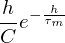

In [6]:
PA_32 = PA.row(2).col(1)[0]
sp.limit(PA_32, tau_s, tau_m)

$2.$ The Taylor-series up to the second order of the function $PA_{32}(\tau_s)$ is:

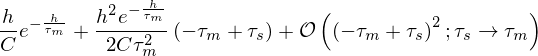

In [7]:
PA_32_series = PA_32.series(x=tau_s,x0=tau_m,n=2)
PA_32_series 

Therefore we have 
 
$T(PA_{32}(\tau_s,\tau_m))=PAs_{32}+PA_{32}^{lin}+O(2)$ where $PA_{32}^{lin}=h^2(-\tau_m + \tau_s)*exp(-h/\tau_m)/(2C\tau_m^2)$
 
$3.$ We define

$dev:=|PA_{32}-PAs_{32}|$
 
We also define $PA_{32}^{real}$ which is the correct value of P32 without misscalculation (instability).
 
In the following we assume $0<|\tau_s-\tau_m|<0.1$. We consider two different cases
 
a) When $dev \geq 2|PA_{32}^{lin}|$ we do not trust the numeric evaluation of $PA_{32}$, since it strongly deviates from the first order correction. In this case the error we make is
 
$|PAs_{32}-PA_{32}^{real}|\approx |P_{32}^{lin}|$
        
b) When $dev \le |2PA_{32}^{lin}|$ we trust the numeric evaluation of $PA_{32}$. In this case the maximal error occurs when $dev\approx 2 PA_{32}^{lin}$ due to numeric instabilities. The order of the error is again

$|PAs_{32}-PA_{32}^{real}|\approx |P_{32}^{lin}|$

The entry $A_{31}$ is numerically unstable, too and we treat it analogously.

## Tests and examples
We will now show that the stability criterion explained above leads to a reasonable behavior for $\tau_s\rightarrow\tau_m$

In [8]:
import nest
import numpy as np
import pylab as pl

Neuron, simulation and plotting parameters

In [9]:
taum = 10.
C_m = 250.
# array of distances between tau_m and tau_ex
epsilon_array = np.hstack(([0.],10.**(np.arange(-6.,1.,1.))))[::-1]
dt = 0.1
fig = pl.figure(1)
NUM_COLORS = len(epsilon_array)
cmap = pl.get_cmap('gist_ncar')
maxVs = []

Loop through epsilon array

In [10]:
for i,epsilon in enumerate(epsilon_array):
    nest.ResetKernel() # reset simulation kernel 
    nest.SetKernelStatus({'resolution':dt})

    # Current based alpha neuron 
    neuron = nest.Create('iaf_psc_alpha') 
    nest.SetStatus(neuron,{'C_m':C_m,'tau_m':taum,'t_ref':0.,'V_reset':-70.,'V_th':1e32,
                           'tau_syn_ex':taum+epsilon,'tau_syn_in':taum+epsilon,'I_e':0.})
   
    # create a spike generator
    spikegenerator_ex=nest.Create('spike_generator')
    nest.SetStatus(spikegenerator_ex,{'spike_times': [50.]})
    
    # create a voltmeter
    vm = nest.Create('voltmeter',params={'interval':dt})

    ## connect spike generator and voltmeter to the neuron

    nest.Connect(spikegenerator_ex, neuron,'all_to_all',{'weight':100.})
    nest.Connect(vm, neuron)

    # run simulation for 200ms
    nest.Simulate(200.) 

    # read out recording time and voltage from voltmeter
    times=nest.GetStatus(vm)[0]['events']['times']
    voltage=nest.GetStatus(vm)[0]['events']['V_m']
    
    # store maximum value of voltage trace in array
    maxVs.append(np.max(voltage))

    # plot voltage trace
    if epsilon == 0.:
        pl.plot(times,voltage,'--',color='black',label='singular')
    else:
        pl.plot(times,voltage,color = cmap(1.*i/NUM_COLORS),label=str(epsilon))

pl.legend()
pl.xlabel('time t (ms)')
pl.ylabel('voltage V (mV)')

Show maximum values of voltage traces

In [11]:
fig = pl.figure(2)
pl.semilogx(epsilon_array,maxVs,color='red',label='maxV')
#show singular solution as horizontal line
pl.semilogx(epsilon_array,np.ones(len(epsilon_array))*maxVs[-1],color='black',label='singular')
pl.xlabel('epsilon')
pl.ylabel('max(voltage V) (mV)')
pl.legend()

In [12]:
pl.show()

The maximum of the voltage traces show that the non-singular case nicely converges to the singular one and no numeric instabilities occur. 